In [6]:
# use of PennyLane’s built-in optimizers to optimize the 2 angles of U2 to rotate qubit form 0 to 1
#  avaliable gradient-based optimizers : https://docs.pennylane.ai/en/stable/introduction/interfaces.html
import pennylane as qml
from jax import numpy as np
import jax
import jaxopt
import matplotlib.pyplot as plt
qcstyle="black_white"

dev1 = qml.device("lightning.qubit", wires=1)  # high performance simulator PennyLane-Lightning

In [3]:
@qml.qnode(dev1)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

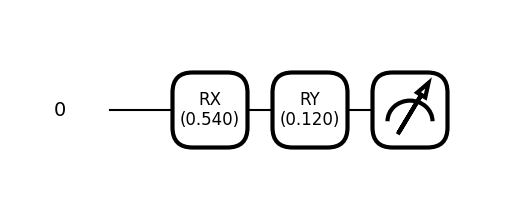

input=[0.54 0.12],  EV=0.852


In [11]:
x0 = np.array([0.54, 0.12])
qml.draw_mpl(circuit, decimals=3, style=qcstyle)(x0)
plt.show()
print('input=%s,  EV=%.3f'%(str(x0),circuit(x0)))

### Calculating quantum gradients
The gradient of the function circuit, encapsulated within the QNode, 

 jax.grad function returns another function,representing the gradient (i.e., the vector of partial derivatives) of circuit.
 The gradient can be evaluated in the same way as the original function

 The function jax.grad itself returns a function, representing the derivative of the QNode with respect to the argument specified in argnums. In this case, the function circuit takes one argument (params), so we specify argnums=0. Because the argument has two elements, the returned gradient is two-dimensional. We can then evaluate this gradient function at any point in the parameter space.
 

In [4]:
x0 = np.array([1.01, 2.01])
dcircuit = jax.grad(circuit, argnums=0) ; print(type(dcircuit))
print('input=%s,  gradient=%s'%(str(x0),str(dcircuit(x0))))

<class 'function'>
input=[1.01 2.01],  gradient=[ 0.36008886 -0.48138213]


In [5]:
# alternative definition of circuit with 2 positional arguments
@qml.qnode(dev1)
def circuit2(phi1, phi2):
    qml.RX(phi1, wires=0)
    qml.RY(phi2, wires=0)
    return qml.expval(qml.PauliZ(0))
# to compute gradient we need to say vs. which argument
'''
 In this case, argnums=0 will return the gradient with respect to only the first parameter (phi1),
 and argnums=1 will give the gradient for phi2. 
 To get the gradient with respect to both parameters, we can use argnums=[0,1]:
 '''
phi1 = np.array([0.54])
phi2 = np.array([0.12])

dcircuit = jax.grad(circuit2, argnums=[0, 1])
print(dcircuit(phi1, phi2))

(Array([-0.51043874], dtype=float32), Array([-0.1026782], dtype=float32))


In [21]:
# setup minimzation problem
def cost(x):
    return circuit(x)

init_params = np.array([0.111, -0.012])
print(cost(init_params))

0.9937743


Cost after step     5:  0.8312094
Cost after step    10: -0.6049964
Cost after step    15: -0.9964512
Cost after step    20: -0.9999785
Cost after step    25: -0.9999999
Cost after step    30: -1.0000000
Cost after step    35: -1.0000000
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [ 3.1415925e+00 -3.1603587e-08]


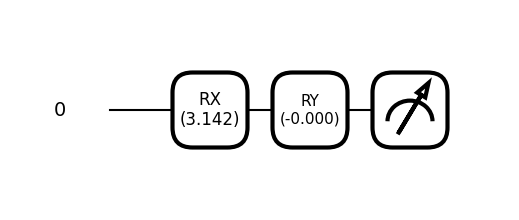

In [22]:
# run minimization
# initialise the optimizer
opt = jaxopt.GradientDescent(cost, stepsize=0.4, acceleration = False)
steps = 100
params = init_params  # set the initial parameter values
opt_state = opt.init_state(params)

for i in range(steps):
    # update the circuit parameters
    params, opt_state = opt.update(params, opt_state)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))
qml.draw_mpl(circuit, decimals=3, style=qcstyle)(params)
plt.show()